In [151]:
#import pygame
import torch
import numpy as np 
import gymnasium as gym
from PIL import Image
from collections import namedtuple

import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 
import random
from itertools import count
import math 

import matplotlib.pyplot as plt 



In [152]:
# DQN is a child class of nn.Module pre buit class in pytorch for NN 

class DQN (nn.Module):       
    def __init__(self, image_h, image_w):
        super(DQN, self).__init__()
        # Xavier initialization : 
        self.fc1 = nn.Linear(in_features= image_h*image_w*3 , out_features= 24 )
        self.fc2 = nn.Linear(in_features= 24  , out_features= 32)
        self.out = nn.Linear (in_features= 32 , out_features= 2 )
    # specifying how input data is processed through the layers of the model to produce an output
    def forward(self , t ):
        t = torch.flatten(t, start_dim=1)
        t = F.relu (self.fc1(t)) 
        t = F.relu (self.fc2(t))
        t = self.out(t)
        return t 

In [153]:
# Exemple of using DQN : 


# Assuming you have multiple images
num_images = 64
image_height = 10
image_width = 10
num_channels = 3  # Assuming RGB channels

# Create an instance of the DQN model
dqn_model = DQN(image_h=image_height, image_w=image_width)

# Generate a batch of dummy input tensors
dummy_input_batch = torch.randn((num_images, num_channels, image_height, image_width))

# Pass the batch of inputs through the model
output_batch = dqn_model(dummy_input_batch)

# Display the model architecture and output
print("DQN Model Architecture:")
print(dqn_model)
print("\nOutput Batch Tensor:")
print(output_batch)
print("input_batch shape : ",dummy_input_batch.shape)
print("output_batch shape : ",output_batch.shape)


DQN Model Architecture:
DQN(
  (fc1): Linear(in_features=300, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

Output Batch Tensor:
tensor([[-0.2014,  0.3056],
        [-0.1044,  0.1576],
        [-0.1533,  0.1968],
        [-0.1219,  0.1583],
        [-0.1811,  0.1754],
        [-0.1051,  0.1855],
        [-0.1455,  0.1970],
        [-0.0828,  0.1842],
        [-0.0135,  0.2333],
        [-0.1102,  0.2576],
        [-0.0753,  0.1468],
        [-0.1401,  0.1540],
        [-0.1537,  0.2525],
        [-0.1023,  0.1435],
        [-0.1193,  0.2362],
        [-0.1076,  0.1475],
        [-0.1207,  0.0463],
        [-0.0168,  0.0128],
        [-0.0114,  0.0836],
        [-0.0847,  0.1962],
        [-0.1500,  0.1615],
        [-0.0815,  0.2943],
        [-0.0905,  0.2877],
        [-0.1496,  0.1618],
        [-0.1190,  0.2129],
        [-0.1604,  0.3170],
        [-0.0962,  0.1919],
        [-0

In [154]:
Experiance = namedtuple (
 'Experiance', 
 ('state', 'action' ,'reward' ,'new_state'  )
)

In [155]:
class ReplayMemory ():
    def __init__(self , capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0 

    def push_experiance (self, experiance):
        if( len(self.memory) < self.capacity):
            self.memory.append(experiance)
            self.count += 1 
        else :
            self.memory[self.count % self.capacity] = experiance
            self.count += 1 

    def sample(self,batch_size):
            return random.sample(self.memory, batch_size)
      
    def can_provide_simple (self,batch_size):
            return (len(self.memory)>= batch_size)


In [156]:
class EpsilonGreedyStrategy():
    def __init__(self, epsilon_max , epsilon_min , epsilon_declay):
        self.epsilon_max = epsilon_max # start 
        self.epsilon_min = epsilon_min  # end
        self.declay = epsilon_declay


    def getExplorationRate(self, current_step):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min)*np.exp(-self.declay*current_step)


In [157]:
class Agent():
    def __init__(self,strategy,num_actions, device):
        self.currant_step = 0 
        self.strategy = strategy
        self.num_actions = num_actions
        self.device= device
        
    def selectAction(self, policy_nn , state, device):
        rate = self.strategy.getExplorationRate(self.currant_step)
        if(rate > random.random()):
             # exploration 
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)
        else:# exploitation
            with torch.no_grad: # turn off the gradient since we are using the nn for training
                return policy_nn(state).argmax(dim = 1 ).to(device)

In [158]:
class CartPoleEnvManager ():
    def __init__(self,device):
        self.device = device 
        self.env = gym.make("CartPole-v1").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done= False 
        self.env.render_mode = "rgb_array"

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self):
        screen = self.env.render()
        self.env.close()
        return screen
    
    def numActionsAvailible(self):
        return self.env.action_space.n
    
    def takeAction (self, action):
          new_state, reward, _  , info, done = self.env.step(action.item()) # .item to transfor the tensor to an action
          self.done = done
          return torch.tensor([reward],device=self.device)
    
    def justStarting (self):
        return self.current_screen is None
    
    def getNumState (self):
        return self.env.observation_space.n

    def getState(self):
        if(self.justStarting()) or self.done:
            self.current_screen = self.get_preprocessed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            self.env.close()
            return black_screen
        else: 
            s1 = self.current_screen
            s2 = self.get_preprocessed_screen()
            self.current_screen = s2 
            self.env.close()
            return s2 - s1 
        
    def getScreenHeight(self):
        return  self.get_preprocessed_screen().shape[2]
    
    def getScreenWidth(self):
        return  self.get_preprocessed_screen().shape[3]
    

    def cropScreen(self, screen ):
        screen_height = screen.shape[1]
        top = int (0.4*screen_height)
        buttom = int (0.8 * screen_height)
        screen = screen[:, top : buttom ,: ]
        return screen
    
    def get_preprocessed_screen(self):
        screen = self.render().transpose((2, 0 , 1))
        screen = self.cropScreen(screen)
        return self.transform_screen_data(screen)
    
    def transform_screen_data(self , screen):
        # convert to float , rescale , convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device)
    
    

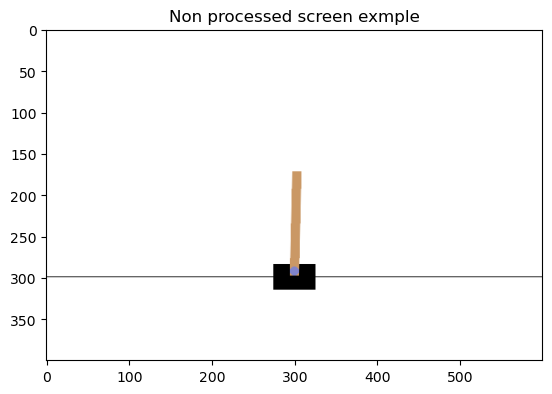

In [159]:
device = "cpu"
em = CartPoleEnvManager(device)
em.reset()
screen = em.render()

plt.figure()
plt.imshow(screen)
plt.title("Non processed screen exmple")
plt.show()

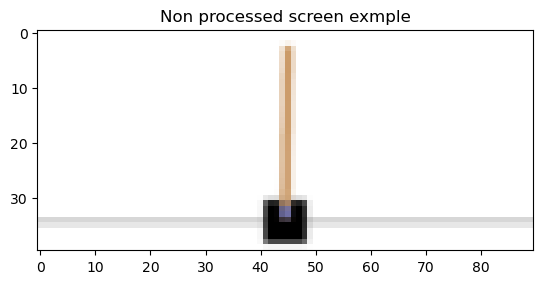

In [160]:
screen = em.get_preprocessed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0),interpolation='none')
plt.title("Non processed screen exmple")
plt.show()

In [161]:
def extract_tensors(experiences):
    batch = Experiance(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward )
    t4 = torch.cat(batch.new_state)

    return (t1,t2,t3,t4)

In [162]:
from sysconfig import is_python_build


def plot(values,moving_avg_period):
    plt.figure(2)
    plt.title("Training ...")
    plt.xlabel('Episodes')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period,values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode",len(values),"\n",\
          moving_avg_period,"episode moving avg: ",moving_avg[-1])
    if is_python_build : display.clear_output (wait = True)


def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >=period:
        moving_avg = values.unfold(dimension = 0 , size = period , step = 1)  \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1)),moving_avg)
        return moving_avg.numpy()
    
    else :
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


In [163]:
class QValues():
    device = "cpu"
    @staticmethod
    def get_current(policy_nn,states,actions):
        return policy_nn(states).gather(dim = 1,index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_nn,nextStates):
        final_state_locations = nextStates.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = nextStates[non_final_state_locations]
        
        
        batch_size = nextStates.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_nn(non_final_states).max(dim=1)[0].detach()
        return values


In [164]:
batch_size =256
discount_rate =0.999
epsilon_max = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
target_update = 10
memory_size = 100000
learning_rate = 0.001
num_episodes = 1000

em = CartPoleEnvManager("cpu")
strategy = EpsilonGreedyStrategy(epsilon_max, epsilon_min, epsilon_decay)
agent = Agent(strategy, em.numActionsAvailible() , "cpu")
replayMemory = ReplayMemory(memory_size)
policy_nn = DQN(em.getScreenHeight(),em.getScreenWidth()).to("cpu")
target_nn = DQN(em.getScreenHeight(),em.getScreenWidth()).to("cpu")

target_nn.load_state_dict(policy_nn.state_dict())
print(policy_nn.state_dict())
target_nn.eval()   # target_nn is not trainble
optimizer = optim.Adam(params=policy_nn.parameters(), lr= learning_rate)


OrderedDict([('fc1.weight', tensor([[ 0.0067, -0.0061,  0.0041,  ...,  0.0071,  0.0086, -0.0030],
        [-0.0080,  0.0063,  0.0062,  ..., -0.0082,  0.0017, -0.0035],
        [-0.0059, -0.0041, -0.0062,  ..., -0.0034,  0.0014, -0.0034],
        ...,
        [ 0.0002, -0.0071, -0.0065,  ..., -0.0050, -0.0094,  0.0034],
        [-0.0012,  0.0051,  0.0045,  ...,  0.0007, -0.0091,  0.0011],
        [-0.0029, -0.0031,  0.0059,  ...,  0.0006,  0.0047, -0.0065]])), ('fc1.bias', tensor([-2.9360e-03,  3.8355e-03,  8.5467e-03,  7.4765e-03,  9.8226e-04,
         8.6020e-03,  1.6896e-03,  3.8333e-03,  7.4862e-03, -4.6197e-03,
         5.0878e-03, -7.3403e-03,  9.1338e-04, -9.5713e-04, -4.4546e-03,
        -8.9980e-03, -3.9159e-05,  6.1999e-03, -9.2741e-03, -6.8805e-04,
         1.4869e-03,  7.9776e-03,  7.5707e-03, -4.5904e-03])), ('fc2.weight', tensor([[ 1.8186e-01, -1.5940e-01, -1.6488e-01,  1.0282e-01, -1.3974e-01,
          1.0063e-01,  1.7680e-01, -1.4529e-01, -4.0091e-02, -1.7679e-01,
     

In [165]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.getState()

    for timestep in count():
        action = agent.selectAction(policy_nn , state , "cpu")
        reward = em.takeAction(action)
        nextState = em.getState()

        replayMemory.push_experiance(Experiance(state,action,reward,nextState))
        state = nextState

        if replayMemory.can_provide_simple(batch_size):
            experiances = replayMemory.sample(batch_size)
            states , actions , rewards , nextStates = extract_tensors(experiances)
            current_q_values = QValues.get_current(target_nn , states , actions)
            next_q_values = QValues.get_next(target_nn , nextStates)
            target_q_values = (next_q_values * discount_rate) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            print("hi")
            plot(episode_durations, 100)
            break
    
    if episode % target_update ==0 :
        target_nn.load_state_dict(policy_nn.state_dict())

em.close()



c:\Users\jn_fe\anaconda3\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


OverflowError: signed short integer is less than minimum